In [5]:
from glob import glob
import os

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from shapely.geometry import box

# optional - turn off warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
os.chdir(os.path.join('users', 'marianne', 'earth-analytics', 'data'))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\Marianne\\earth-analytics\\data'

In [9]:
path = os.path.join("reg9_eco_l3", "reg9_eco_l3.shp")

eco_bound = gpd.read_file(path)

eco_bound[eco_bound['US_L3CODE']=='7']

DriverError: reg9_eco_l3\reg9_eco_l3.shp: No such file or directory

NameError: name 'eco_bound' is not defined

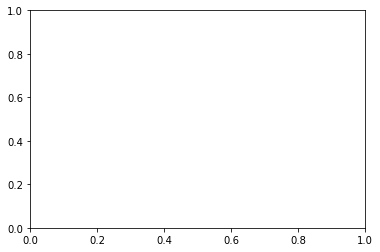

In [8]:
fig,ax = plt.subplots()
eco_bound[eco_bound['US_L3CODE']=='7'].plot(ax=ax,color="green")
cv = eco_bound[eco_bound['US_L3CODE']=='7']



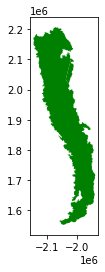

In [40]:
fig,ax = plt.subplots()
eco_bound[eco_bound['US_L3CODE']=='5'].plot(ax=ax,color="green")
sn = eco_bound[eco_bound['US_L3CODE']=='5']

In [20]:
filepath = os.path.join('MOD17/GeoTIFF/Monthly_MOD17A2','MOD17A2_GPP.2004.M08.tif')

modis_pre = rxr.open_rasterio(filepath,
                              masked=True)

<AxesSubplot:>

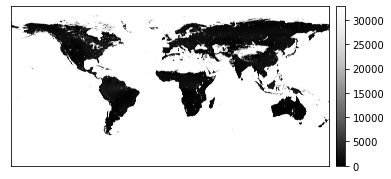

In [33]:
fig,ax=plt.subplots()
ep.plot_bands(modis_pre,ax=ax)
#eco_bound[eco_bound['US_L3CODE']=='5'].plot(ax=ax)

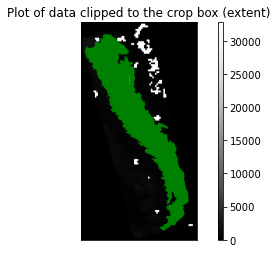

In [42]:
sn_trans = sn.to_crs(modis_pre.rio.crs)
from rasterio.plot import plotting_extent

#  Create a box representing the spatial extent of your data
crop_bound_box = [box(*sn.total_bounds)]
# Clip the data by  chaining together rio.clip with rio.open_rasterio
# from_disk=True allows you to only open the data that you wish to work with
modis_pre_clip = modis_pre.rio.clip(crop_bound_box,
                                                                    crs=sn.crs,
                                                                    # Include all pixels even partial pixels
                                                                    all_touched=True,
                                                                    from_disk=True).squeeze()
# The final clipped data
modis_pre_clip


modis_ext = plotting_extent(modis_pre_clip,
                            modis_pre_clip.rio.transform())

                            # View cropped data
f, ax = plt.subplots()
ep.plot_bands(modis_pre_clip,
              ax=ax,
              extent=modis_ext,
              title="Plot of data clipped to the crop box (extent)")
sn_trans.plot(ax=ax,
                    color="green")
plt.show()




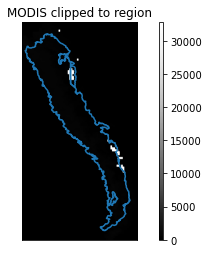

8588

In [98]:
fig,ax=plt.subplots()
sn_geom = sn.to_crs(modis_pre.rio.crs)

modis_ext = plotting_extent(modis_pre_clip,
                            modis_pre_clip.rio.transform())
# MODIS Clipped to Geometry
modis_clip = modis_pre.rio.clip(sn_geom.geometry,
                                               all_touched=True,
                                               from_disk=True)

                                      
modis_clip_plot = ma.masked_array(modis_clip.values, modis_clip.isnull())


extent = plotting_extent(modis_clip[0].values, modis_clip.rio.transform())

# Plotting Bounds Clip
ep.plot_bands(modis_clip_plot,
            ax=ax,
            extent=modis_ext,
            title='MODIS clipped to region')

sn_trans.boundary.plot(ax=ax)

plt.show()
modis_clip.size

In [ ]:
modis_pre = np.zeros((16,13,1200,1200))
for y in range(2000,2016):
    for m in range(1,13):
        if(m<10):
            ms='M0'+str(m)
        else:
            ms = 'M'+str(m)
        yr = 'Y'+str(y)

        path = os.path.join('modis-gpp/data/NTSG_Products/MOD17/TrashCan/Monthly_MOD17A2',yr,ms) # ,'*h08v05*.hdf')
        os.listdir(path)
        filepath = os.path.join(path,os.listdir(path)[0])
        modis_pre[y-2000][m] = rxr.open_rasterio(filepath,masked=True)['Gpp_1km']


In [ ]:
import pandas as pd
mod_all = np.zeros((20,13,113,76))
files = os.listdir('MOD17/GeoTIFF/Monthly_MOD17A2')
for f in files:
    fp = os.path.join('MOD17/GeoTIFF/Monthly_MOD17A2',f)
    modis_pre = rxr.open_rasterio(fp,
                              masked=True)
    modis_clip = modis_pre.rio.clip(sn_geom.geometry,
                    all_touched=True,
                    from_disk=True)
    yr = f.split(".")[1]
    year = int(yr)-2000
    mo = f.split(".")[2].split("M")[1]
    month = int(mo)
    mod_all[year,month,:,:] = modis_clip
   

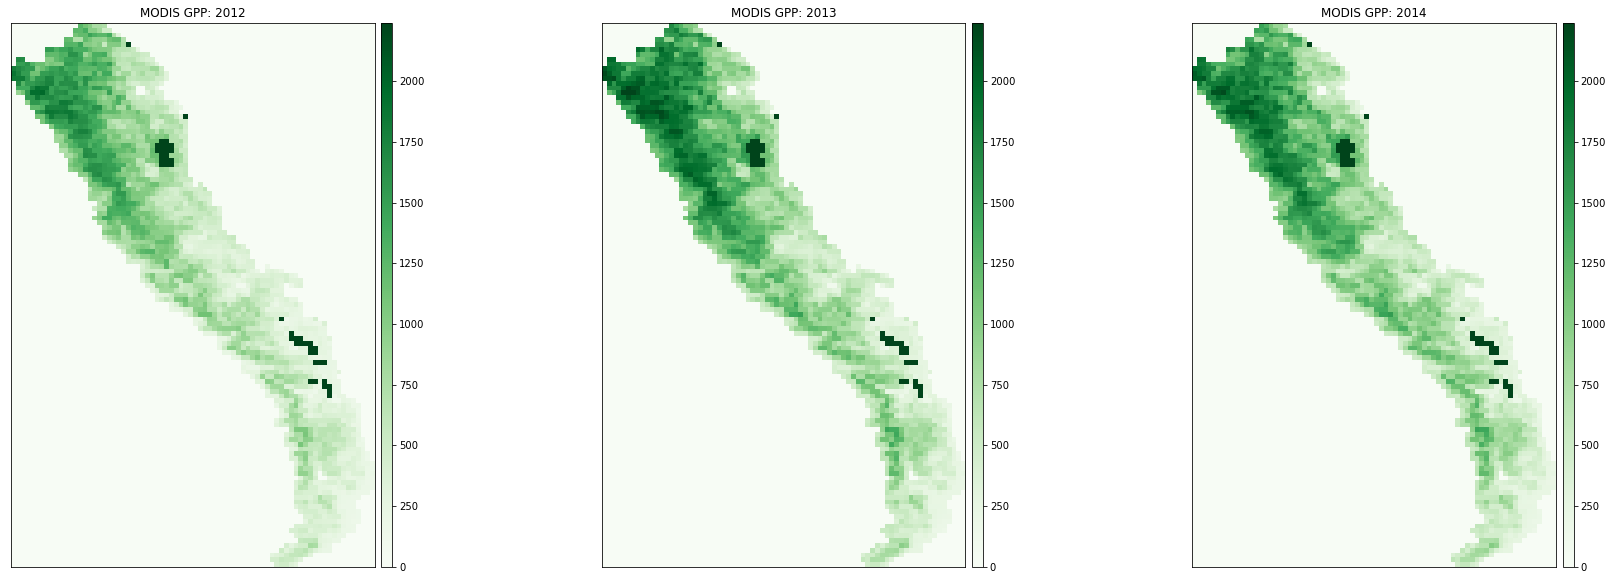

In [201]:
fig,ax=plt.subplots(1,3,figsize=(30,10))
# Plotting Bounds Clip
month = 8
year = 12
maxval = np.nanmean(mod_all[year,month,:,:]) + 0.8*np.nanstd(mod_all[year,month,:,:])
for i in range(year,year+3):
    ep.plot_bands(mod_all[i,month,:,:],
                ax=ax[i-year],
                extent=modis_ext,
                title='MODIS GPP: '+str(2000+i),
                cbar=True, 
                cmap = 'Greens',
                vmin=0, vmax=maxval)


In [292]:
modis_ext

(-121.75, -117.60000000000001, 34.550000000000004, 40.75)

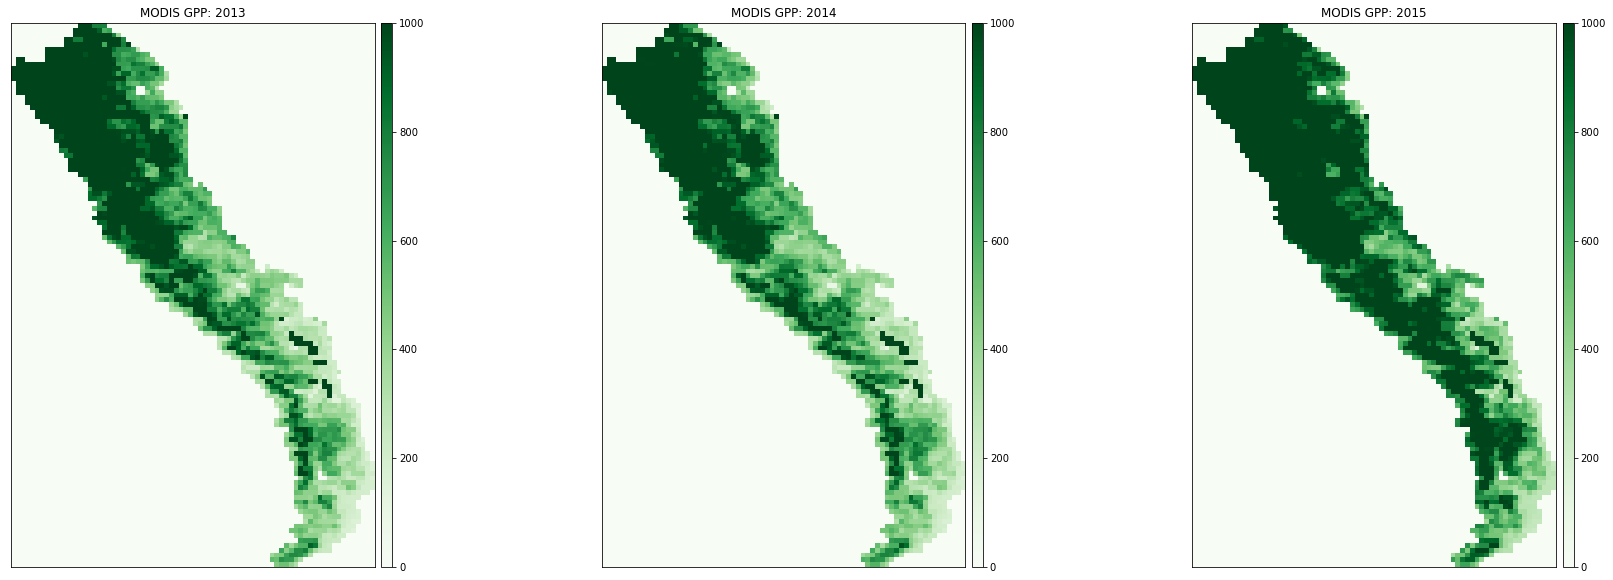

In [169]:
fig,ax=plt.subplots(1,3,figsize=(30,10))
for i in range(13,16):
    ep.plot_bands(mod_all[i,7,:,:],
                ax=ax[i-13],
                extent=modis_ext,
                title='MODIS GPP: '+str(2000+i),
                cbar=True, 
                cmap = 'Greens',
                vmin=0, vmax=1000)


In [10]:
os.chdir('/users/marianne/documents/pe_snow_fires')
sn_watersheds= gpd.read_file('data/sn_watersheds.shp')
mtbs= gpd.read_file('mtbs_perimeter_data/mtbs_perims_DD.shp')

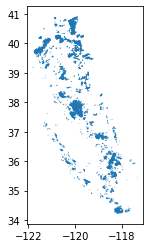

In [19]:
bounds2 = gpd.sjoin(mtbs,sn_watersheds)
# fig,ax=plt.subplots(1,1,figsize=(30,10))
bounds2.plot()
bounds2.to_file('firebounds_sn.gdf')

<AxesSubplot:>

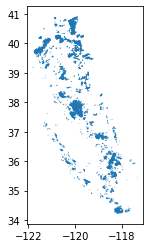

In [15]:
bounds2.plot()

In [279]:

tmp = np.zeros([25,1024])
xs =  np.arange(0,2*np.pi,2*np.pi/1024)
ys = [int(i) for i in (np.floor(25/2 + 24/2 * np.sin(xs)))]
for i in range(1024):
    tmp[ys[i],i] = 1

In [278]:
len(ys)

512

In [280]:
np.savetxt('tmp.txt',tmp,fmt='%1i')